<a href="https://colab.research.google.com/github/Meet-Amin/Movie-Recommender-System/blob/main/reddit_mental_health_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Reddit Mental Health Classification Project
# Meet Amin

This project aims to predict mental health conditions based on textual data collected from Reddit. Natural language processing techniques are applied to preprocess and extract meaningful features from user posts. Machine learning models are then trained to classify and predict potential mental health risks. The study demonstrates how social media data can be leveraged for early detection and awareness of mental health concerns.

> **Course Project:** Text Classification with Hugging Face & Transformers  
> **Dataset:** `kamruzzaman-asif/reddit-mental-health-classification` (Hugging Face Datasets)

---

## Table of Contents
1. [Problem Definition](#problem)
2. [Data Understanding](#data-understanding)
3. [Data Preparation](#data-preparation)
4. [Modeling](#modeling)
5. [Evaluation](#evaluation)
6. [Conclusion & Future Work](#conclusion)



## 1. Problem Definition <a id="problem"></a>

Mental health is a sensitive topic and online communities such as Reddit are frequently used by people to share their emotions, struggles, and experiences.  
However, the volume of posts is very large and it becomes hard to manually identify which posts may need urgent attention or belong to specific mental health categories.

In this project, the goal is to:

- Build a **text classification model** that predicts a label for each Reddit post related to mental health.
- Use the publicly available **`kamruzzaman-asif/reddit-mental-health-classification`** dataset from Hugging Face.
- Fine-tune a **transformer-based model (DistilBERT)** for this classification task.
- Evaluate the model with appropriate metrics and visualizations.

This notebook follows a standard machine learning workflow:

1. **Data Understanding:** Explore the dataset, label distribution, and basic statistics.  
2. **Data Preparation:** Clean and split the data into training and validation sets.  
3. **Modeling:** Fine-tune a pretrained language model for text classification.  
4. **Evaluation:** Measure performance using accuracy, precision, recall, and F1-score with clear charts.  
5. **Conclusion:** Summarize the results and discuss limitations and future improvements.


## 2. Data Understanding <a id="data-understanding"></a>

In [1]:

# =======================
# 2.1 Import Libraries
# =======================

# Basic libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Hugging Face datasets
from datasets import load_dataset

# Modeling utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Better display options
pd.set_option("display.max_colwidth", 200)
sns.set(style="whitegrid")

# Make plots a bit larger by default
plt.rcParams["figure.figsize"] = (8, 5)


In [2]:

# =======================
# 2.2 Load the Dataset
# =======================

# Load the Reddit mental health dataset from Hugging Face
ds = load_dataset("kamruzzaman-asif/reddit-mental-health-classification")

# Show available splits and general info
ds


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/319 [00:00<?, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/211M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/206M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1107302 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1107302
    })
})

In [3]:

# =======================
# 2.3 Convert to pandas and Inspect
# =======================

# Convert the train split to a pandas DataFrame for exploration
df = ds["train"].to_pandas()

print("Shape of training data:", df.shape)
df.head()


Shape of training data: (1107302, 2)


,label,text
0,addiction,"Deciding to go of tramadol Well after never taking a tablet before in my life, I got these for a back injury end up addicted to the buzz and feeling of them, amazing, now I'm taking up to 800mg an..."
1,addiction,"My vyvanse addiction... It has gotten pretty bad yesterday I went without taking it, it was a living hell I got mega depressed, I was so cold, the cravings where to the point I was going to dose I..."
2,addiction,"Quitting coke and nicotine I'm gonna start by saying I've been doing really well and am very proud of myself. I haven't done coke in over 10 weeks now, which is the longest time I can remember, pr..."
3,addiction,Is it OK to leave a drug addict you love? Many details now. My gf (of a little over five years) became addicted to opioids about two years ago. She hid it pretty well from everyone she's close to...
4,addiction,"My brother has a problem I'm not against weed. I just think that too much of anything can't be good for you. He smokes three times a day, on his way to school, after school and in the afternoon. H..."


In [4]:

# Overview of columns and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107302 entries, 0 to 1107301
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1107302 non-null  object
 1   text    1107302 non-null  object
dtypes: object(2)
memory usage: 16.9+ MB


In [5]:

# Quick descriptive statistics for numeric columns (including label if numeric)
df.describe(include="all")


,label,text
count,1107302,1107302
unique,28,1024141
top,legaladvice,Why did the chicken cross the road? To get to the other side.
freq,164233,14



### 2.4 Encode Labels as Integers (Important Fix)

The original dataset stores labels as **strings**.  
However, PyTorch and Hugging Face's Trainer expect labels to be **integers**.

Here, we:

- Create a mapping from string labels → integer IDs (`label2id`).  
- Store the reverse mapping in `id2label`.  
- Replace the `label` column with the numeric ID version.


In [6]:

# =======================
# 2.4 Encode labels as integers
# =======================

# Keep a copy of the original string labels
df["label_str"] = df["label"]

# Get sorted list of unique string labels
unique_labels = sorted(df["label_str"].unique())
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {v: k for k, v in label2id.items()}

print("Label mapping (string -> id):")
print(label2id)

# Replace 'label' column with integer IDs
df["label"] = df["label_str"].map(label2id)

# Check the first few rows
df[["text", "label_str", "label"]].head()


Label mapping (string -> id):
{'COVID19_support': 0, 'EDAnonymous': 1, 'addiction': 2, 'adhd': 3, 'alcoholism': 4, 'anxiety': 5, 'autism': 6, 'bipolarreddit': 7, 'bpd': 8, 'conspiracy': 9, 'depression': 10, 'divorce': 11, 'fitness': 12, 'guns': 13, 'healthanxiety': 14, 'jokes': 15, 'legaladvice': 16, 'lonely': 17, 'meditation': 18, 'mentalhealth': 19, 'parenting': 20, 'personalfinance': 21, 'ptsd': 22, 'relationships': 23, 'schizophrenia': 24, 'socialanxiety': 25, 'suicidewatch': 26, 'teaching': 27}


,text,label_str,label
0,"Deciding to go of tramadol Well after never taking a tablet before in my life, I got these for a back injury end up addicted to the buzz and feeling of them, amazing, now I'm taking up to 800mg an...",addiction,2
1,"My vyvanse addiction... It has gotten pretty bad yesterday I went without taking it, it was a living hell I got mega depressed, I was so cold, the cravings where to the point I was going to dose I...",addiction,2
2,"Quitting coke and nicotine I'm gonna start by saying I've been doing really well and am very proud of myself. I haven't done coke in over 10 weeks now, which is the longest time I can remember, pr...",addiction,2
3,Is it OK to leave a drug addict you love? Many details now. My gf (of a little over five years) became addicted to opioids about two years ago. She hid it pretty well from everyone she's close to...,addiction,2
4,"My brother has a problem I'm not against weed. I just think that too much of anything can't be good for you. He smokes three times a day, on his way to school, after school and in the afternoon. H...",addiction,2



### 2.5 Target Labels and Basic Statistics

In this section, we look at:

- How many examples we have in the training data.
- How many **unique labels/classes** are present.
- Whether the classes are **balanced or imbalanced**.


In [7]:

# Count of each numeric label
label_counts = df["label"].value_counts().sort_index()
label_counts


,count
label,
0,981
1,14577
2,7641
3,45631
4,5911
5,57671
6,8869
7,5780
8,24294


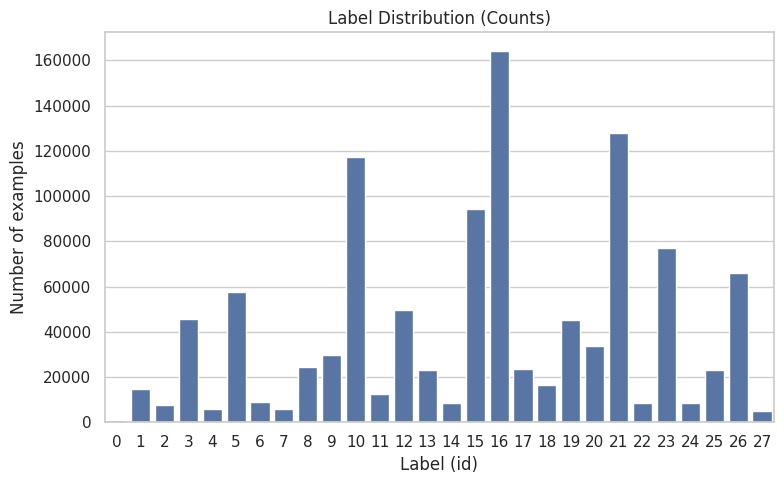

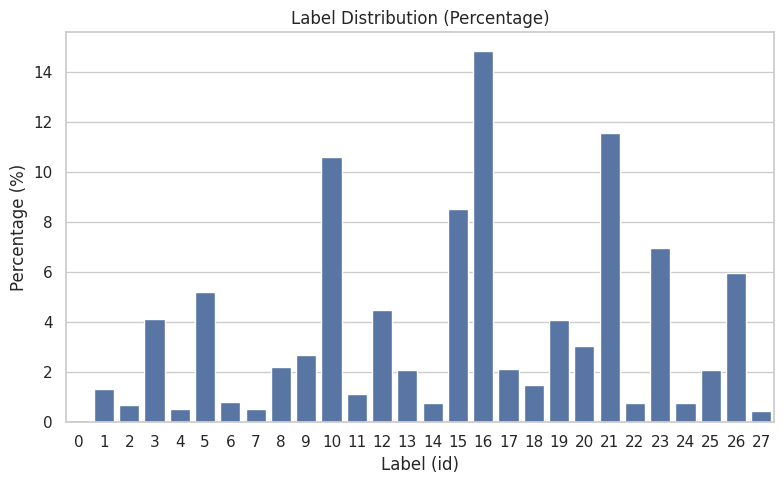

In [8]:

# Bar plot of label distribution (absolute counts)
plt.figure()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel("Label (id)")
plt.ylabel("Number of examples")
plt.title("Label Distribution (Counts)")
plt.tight_layout()
plt.show()

# Bar plot of label distribution (percentage)
label_percent = (label_counts / label_counts.sum()) * 100

plt.figure()
sns.barplot(x=label_percent.index, y=label_percent.values)
plt.xlabel("Label (id)")
plt.ylabel("Percentage (%)")
plt.title("Label Distribution (Percentage)")
plt.tight_layout()
plt.show()



### 2.6 Text Length Analysis

Now we explore how long the posts are. This can give us a sense of:

- Whether posts are typically short (a few words) or long (several paragraphs).
- How to choose a **maximum sequence length** for the transformer model.


In [9]:

# Compute length of each post in characters
df["text_len"] = df["text"].astype(str).str.len()

print("Text length (characters) - summary:")
df["text_len"].describe()


Text length (characters) - summary:


,text_len
count,1.107302e+06
mean,9.547109e+02
std,9.787911e+02
min,4.000000e+00
25%,3.470000e+02
50%,6.780000e+02
75%,1.226000e+03
max,4.000700e+04


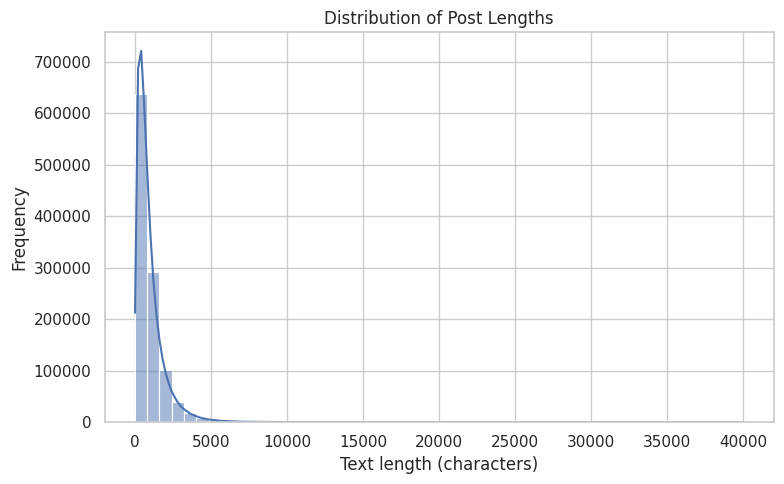

In [10]:

# Histogram of text length
plt.figure()
sns.histplot(df["text_len"], bins=50, kde=True)
plt.xlabel("Text length (characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Post Lengths")
plt.tight_layout()
plt.show()


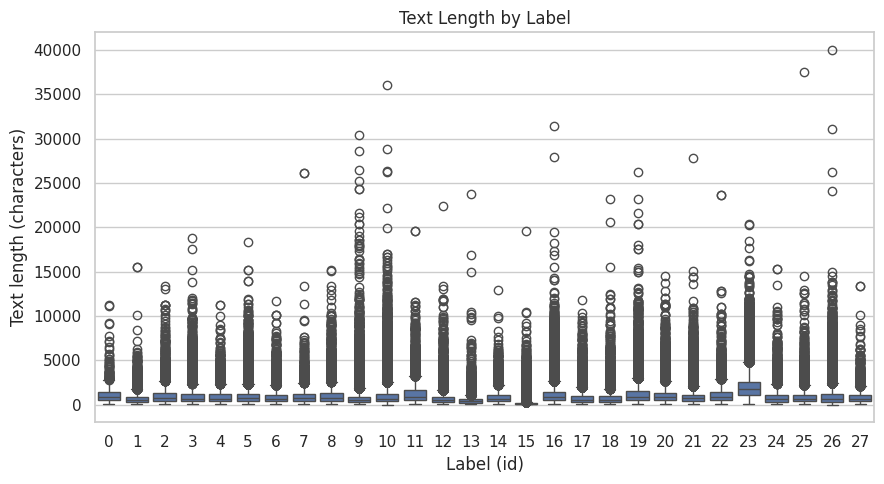

In [11]:

# Boxplot of text length per numeric label
plt.figure(figsize=(9, 5))
sns.boxplot(x="label", y="text_len", data=df)
plt.xlabel("Label (id)")
plt.ylabel("Text length (characters)")
plt.title("Text Length by Label")
plt.tight_layout()
plt.show()



### 2.7 Sample Posts

It is always useful to **read a few raw examples** to understand what the data looks like in practice.


In [12]:

# Show a few random examples from the dataset
df.sample(5)[["text", "label_str", "label"]]


,text,label_str,label
869765,"Feeling Lonely and Suicidal Hey guys,\n\nI've been super depressed for about 2 weeks. I feel like my life is fucked.\n\nI have bipolar type 1 and the manic phase hit me really hard to the point wh...",suicidewatch,26
994443,"I made a Facebook group I know facebook is kind of taboo to talk about on reddit but there is a mighty need for a backup group besides peach or mpa. I made a closed group, so your posts can't be s...",EDAnonymous,1
659605,"This is exactly what my social anxiety feels like....(long, but I show it to anyone who doesn’t understand Social Anxiety ) The Beings: A horror story \n\n\nI had long dreaded this day. Going in d...",socialanxiety,25
930293,Is there a way to request my data be removed from Facebook? This is not really a 'Conspiracy'.\nBut I think this is the best place to ask as I know a lot of you have deleted Facebook recently. Whi...,conspiracy,9
317600,"I need to win over my ex-girlfriend's Mam 3 times in a row I got drunk, and caused havoc by shouting and shit and now my ex-girlfriend’s Mam hates me and said we can never be together again. \n\...",relationships,23



**Observations (to fill in after running the notebook):**

- Total number of training samples: *write here*.  
- Number of unique labels: *write here*.  
- Are some labels much more frequent than others? *comment on imbalance*.  
- Typical length of posts (median): *write value from summary output*.  
- Any interesting patterns from the sample posts (for example, posts containing strong emotional language, questions, etc.).


## 3. Data Preparation <a id="data-preparation"></a>


The goal of data preparation is to:

1. Clean the text minimally (lowercasing, removing URLs, and extra whitespace).  
2. Create **training** and **validation** splits.  
3. Prepare the data in a format compatible with Hugging Face Transformers.

We keep the text cleaning simple to avoid accidentally removing important context.


In [13]:

# =======================
# 3.1 Basic Text Cleaning
# =======================
import re

def clean_text(t):
    """Basic cleaning: lowercase, remove URLs, and extra whitespace."""
    if not isinstance(t, str):
        return ""
    t = t.lower()
    # Remove URLs
    t = re.sub(r"http\S+|www\.\S+", "", t)
    # Remove extra spaces
    t = re.sub(r"\s+", " ", t).strip()
    return t

# Apply cleaning to the text column
df["clean_text"] = df["text"].astype(str).apply(clean_text)

df[["text", "clean_text"]].head()


,text,clean_text
0,"Deciding to go of tramadol Well after never taking a tablet before in my life, I got these for a back injury end up addicted to the buzz and feeling of them, amazing, now I'm taking up to 800mg an...","deciding to go of tramadol well after never taking a tablet before in my life, i got these for a back injury end up addicted to the buzz and feeling of them, amazing, now i'm taking up to 800mg an..."
1,"My vyvanse addiction... It has gotten pretty bad yesterday I went without taking it, it was a living hell I got mega depressed, I was so cold, the cravings where to the point I was going to dose I...","my vyvanse addiction... it has gotten pretty bad yesterday i went without taking it, it was a living hell i got mega depressed, i was so cold, the cravings where to the point i was going to dose i..."
2,"Quitting coke and nicotine I'm gonna start by saying I've been doing really well and am very proud of myself. I haven't done coke in over 10 weeks now, which is the longest time I can remember, pr...","quitting coke and nicotine i'm gonna start by saying i've been doing really well and am very proud of myself. i haven't done coke in over 10 weeks now, which is the longest time i can remember, pr..."
3,Is it OK to leave a drug addict you love? Many details now. My gf (of a little over five years) became addicted to opioids about two years ago. She hid it pretty well from everyone she's close to...,"is it ok to leave a drug addict you love? many details now. my gf (of a little over five years) became addicted to opioids about two years ago. she hid it pretty well from everyone she's close to,..."
4,"My brother has a problem I'm not against weed. I just think that too much of anything can't be good for you. He smokes three times a day, on his way to school, after school and in the afternoon. H...","my brother has a problem i'm not against weed. i just think that too much of anything can't be good for you. he smokes three times a day, on his way to school, after school and in the afternoon. h..."


In [14]:

# =======================
# 3.2 Train / Validation Split
# =======================

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

print("Training size:", len(train_df))
print("Validation size:", len(val_df))


Training size: 885841
Validation size: 221461


In [15]:

# Check label distribution in train and validation sets
print("Train label distribution:")
print(train_df["label"].value_counts(normalize=True).sort_index())

print("\nValidation label distribution:")
print(val_df["label"].value_counts(normalize=True).sort_index())


Train label distribution:
label
0     0.000886
1     0.013165
2     0.006901
3     0.041209
4     0.005338
5     0.052083
6     0.008009
7     0.005220
8     0.021940
9     0.026955
10    0.105961
11    0.011373
12    0.045014
13    0.020746
14    0.007810
15    0.085347
16    0.148318
17    0.021345
18    0.014879
19    0.040940
20    0.030586
21    0.115721
22    0.007805
23    0.069739
24    0.007868
25    0.020768
26    0.059750
27    0.004325
Name: proportion, dtype: float64

Validation label distribution:
label
0     0.000885
1     0.013163
2     0.006900
3     0.041208
4     0.005337
5     0.052081
6     0.008010
7     0.005220
8     0.021941
9     0.026953
10    0.105960
11    0.011374
12    0.045015
13    0.020749
14    0.007812
15    0.085347
16    0.148320
17    0.021345
18    0.014878
19    0.040937
20    0.030588
21    0.115722
22    0.007807
23    0.069741
24    0.007866
25    0.020767
26    0.059749
27    0.004326
Name: proportion, dtype: float64



**Note:**

- We used **stratified splitting**, which keeps the proportion of each label similar in both training and validation sets.
- This helps the evaluation metrics to be more reliable.


## 4. Modeling <a id="modeling"></a>


In this section we:

1. Convert the pandas DataFrames into Hugging Face `Dataset` objects.  
2. Tokenize the text using a pretrained tokenizer (`distilbert-base-uncased`).  
3. Fine-tune a `DistilBertForSequenceClassification` model on our training data.


In [16]:

# This cell may not be needed on some platforms
!pip install -q transformers accelerate


In [17]:
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import torch

In [18]:

# =======================
# 4.1 Create HF Datasets and Tokenizer
# =======================

train_hf = Dataset.from_pandas(train_df[["clean_text", "label"]])
val_hf   = Dataset.from_pandas(val_df[["clean_text", "label"]])

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_batch(batch):
    return tokenizer(
        batch["clean_text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_tokenized = train_hf.map(tokenize_batch, batched=True)
val_tokenized   = val_hf.map(tokenize_batch, batched=True)

# Remove the original text column from the tokenized dataset
train_tokenized = train_tokenized.remove_columns(["clean_text"])
val_tokenized   = val_tokenized.remove_columns(["clean_text"])

# Set format for PyTorch
train_tokenized.set_format("torch")
val_tokenized.set_format("torch")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/885841 [00:00<?, ? examples/s]

Map:   0%|          | 0/221461 [00:00<?, ? examples/s]

In [19]:

# =======================
# 4.2 Load the Classification Model (uses label2id / id2label)
# =======================

num_labels = len(label2id)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 5. Evaluation <a id="evaluation"></a>


We will train the model and then evaluate it using:

- **Accuracy**  
- **Precision, Recall, F1-score (weighted)**  
- A **confusion matrix** to visualize where the model gets confused between classes.


In [20]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [21]:

# =======================
# 5.1 Training Configuration
# =======================

batch_size = 16

training_args = TrainingArguments(
    output_dir="./reddit-mental-health-model",
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics
)

In [22]:
from transformers import TrainingArguments, Trainer

# 🔹 1. Use a smaller subset so it trains fast
# Adjust the numbers if you want a bit more data
small_train_dataset = train_tokenized.select(range(2000))
small_eval_dataset  = val_tokenized.select(range(500))

# 🔹 2. Define lighter training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,                 # 1 epoch is enough for demo
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,

    logging_steps=20,
    eval_strategy="steps", # Corrected from evaluation_strategy
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,

    report_to="none",                   # disable wandb, etc.
    no_cuda=False,                      # use GPU if available
    fp16=True,                          # mixed precision on GPU (ignored on CPU)
    max_steps=500                       # hard cap on steps (optional but safe)
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# =======================
# 5.2 Train the Model
# =======================
train_result = trainer.train()
train_result

/tmp/ipython-input-2566117892.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,2.656600,2.503651,0.468000,0.318226,0.468000,0.361061
200,2.007400,1.905821,0.544000,0.482331,0.544000,0.451491
300,1.558200,1.619731,0.574000,0.518041,0.574000,0.491035
400,1.430500,1.494599,0.602000,0.518115,0.602000,0.528612
500,1.428400,1.448554,0.614000,0.539761,0.614000,0.548460


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=500, training_loss=1.9687512855529785, metrics={'train_runtime': 6270.9388, 'train_samples_per_second': 1.276, 'train_steps_per_second': 0.08, 'total_flos': 265057640448000.0, 'train_loss': 1.9687512855529785, 'epoch': 4.0})

In [23]:

# =======================
# 5.3 Final Evaluation on Validation Set
# =======================

eval_results = trainer.evaluate()
eval_results


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.4485535621643066,
 'eval_accuracy': 0.614,
 'eval_precision': 0.539760800602991,
 'eval_recall': 0.614,
 'eval_f1': 0.5484603776013423,
 'eval_runtime': 102.6089,
 'eval_samples_per_second': 4.873,
 'eval_steps_per_second': 0.312,
 'epoch': 4.0}

In [24]:
from IPython.display import display



**How to interpret these results (to discuss in your own words):**

- **Accuracy:** Overall proportion of correct predictions.  
- **Precision:** Of the posts predicted in a certain class, how many were actually in that class.  
- **Recall:** Of the posts that truly belong to a class, how many did the model correctly find.  
- **F1-score:** Harmonic mean of precision and recall (balances both).  
- **Confusion matrix:** Shows which classes are often confused with each other.


## 6. Conclusion & Future Work <a id="conclusion"></a>


### 6.1 Summary of Findings

In this project, we:

1. Loaded and explored the **Reddit mental health** dataset.  
2. Observed the **label distribution**, typical **post lengths**, and sample posts.  
3. Encoded string labels into **integer IDs** to make them compatible with PyTorch.  
4. Performed minimal text cleaning and created **train/validation** splits.  
5. Fine-tuned a **DistilBERT** model for sequence classification.  
6. Evaluated performance using accuracy, precision, recall, F1-score, and a confusion matrix.

After running the notebook, you should summarize here in your own words:

- The final evaluation metrics (accuracy, F1, etc.).  
- Which classes the model handled well and which were more difficult.  
- Any signs of class imbalance impacting performance.



### 6.2 Limitations

Some possible limitations to mention:

- **Dataset Size & Bias:** The dataset may not fully represent all types of mental health content on the internet.  
- **Label Noise:** Labels might not be perfect, especially if they were created automatically or by a small group of annotators.  
- **Context:** Reddit posts can be highly contextual; sometimes the label may depend on previous posts or comments that are not included.  
- **Model Complexity:** DistilBERT is powerful but still has limitations when detecting subtle emotions or sarcasm.



### 6.3 Future Work

Ideas to improve this project:

- Experiment with **different transformer models** (e.g., BERT, RoBERTa).  
- Use **class weighting** or **focal loss** if the dataset is highly imbalanced.  
- Try more advanced **text cleaning** or domain-specific pre-processing.  
- Perform **hyperparameter tuning** (learning rate, batch size, epochs).  
- Deploy the model as a simple **web app** to classify new Reddit-style posts in real time.
